In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as integrate
import gif

In [2]:
# constants in pc-M_sol-Ma units:
#G = 0.004491

# constants in kpc-1e10Msol-Ga units:
#G = 44910

# constants in cgs units:
G = 6.674e-8
M_sol = 1.988e33

In [14]:
# vector from p_1 towards p_2:
def distance(p_1, p_2):
    return p_2 - p_1

# absolute of a 3-vector:
def absolute(v):
    return np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)

# gravitational acceleration between particles i and j:
def grav_acc(m_j, d_ij, softening = 0):
    #print(G * m_j * d_ij / (absolute(d_ij)**3))
    return G * m_j * d_ij / ((absolute(d_ij) + softening)**3)

In [34]:
# find the acceleration tensor:
def acc_tensor(positions, masses):
    a = np.zeros((3, n, n))
    for i in range(n):
        for j in range(i+1, n):    
            d_ij = distance(positions[:, i], positions[:, j])
            a[:, i, j] = grav_acc(masses[j], d_ij, softening) #acceleration on particle i from particle j
            a[:, j, i] = grav_acc(masses[i], -d_ij, softening) #acceleration on particle j from particle i
    return a

In [16]:
# find the total acceleration on particle i:   (inefficient!)
def cumulative_acc(positions, masses, i):
    a = np.zeros(3)
    for j in range(0, n):    #acceleration from particle j
        if j == i:
            a = a
        else:
            d_ij = distance(positions[:, i], positions[:, j])
            #print(d_ij)
            a = a + grav_acc(masses[j], d_ij)
    return a

In [37]:
# initial setup of the system (units!):

# all txt files contain (3, n)-arrays where n gives the number of particles
# positions
positions = np.loadtxt('Initial_Setup/initial_positions.txt')
# velocities
velocities = np.loadtxt('Initial_Setup/initial_velocities.txt')

# number of particles
n = 9 #np.size(positions, 1)
# number of timesteps
T = 1000
# length of one time step (units!)
t = 86400 * 10
# accelerations
accelerations = np.zeros((3, n))
# masses (plus one heavier mass) (units!)
masses = np.loadtxt('Initial_Setup/masses.txt')
#masses = np.append(masses, 2e8)
#masses = np.ones(n) * 1e-3
# softening parameter (units!)
softening = 0


# Leapfrog Integrator:

# file templates
pos_template = 'Positions/k{i}positions.txt'
vel_template = 'Velocities/k{i}velocities.txt'
acc_template = 'Accelerations/k{i}accelerations.txt'
# 0-step velocities and positions
np.savetxt(vel_template.format(i=0), velocities)
np.savetxt(pos_template.format(i=0), positions)

# 0-step accelerations:
for i in range(n):
    #print(accelerations)
    accelerations[:, i] = cumulative_acc(positions, masses, i)
np.savetxt(acc_template.format(i=0), accelerations)

# outer loop for every time step:
for k in range(1, T):
    # update the position for all particles
    positions += t * velocities + .5 * t**2 * accelerations
    # save the new positions array
    np.savetxt(pos_template.format(i=k), positions)
    
    #remember the last acceleration
    accelerations_prior = accelerations
    
    # acceleration using individual calculations
    #for i in range(n):
    #    accelerations[:, i] = cumulative_acc(positions, masses, i)
    
    # accelerations using acceleration tensor
    a = acc_tensor(positions, masses)
    accelerations = np.sum(a, axis = 2)
    
    # save the new accelerations array
    np.savetxt(acc_template.format(i=k), accelerations)
    
    # update the velocities for all particles
    velocities += .5 * t * (accelerations_prior + accelerations)
    # save the new velocities array
    np.savetxt(vel_template.format(i=k), velocities)

In [30]:
# Plot the Results projected into the x-y-plane
@gif.frame
def plot(i):
    positions = np.loadtxt('Positions/k{i}positions.txt'.format(i=i))
    x_positions = positions[0, :]
    y_positions = positions[1, :]
    z_positions = positions[2, :]
    plt.figure(figsize=(10,10))
    plt.scatter(x_positions, y_positions, s=8)
    plt.xlim((-5e14, 5e14))
    plt.ylim((-5e14, 5e14))
    
def radii():
    radiuses = np.zeros((n, T))
    for i in range(T):
        positions = np.loadtxt('Positions/k{i}positions.txt'.format(i=i))
        for j in range(n):
            radiuses[j, i] = absolute(positions[:, j])
    return radiuses

In [39]:
frames = []
for i in range(T):
    frame = plot(i)
    frames.append(frame)
    
gif.save(frames, 'Gifs/n_body_system.gif', duration=20, unit='s', between='startend')

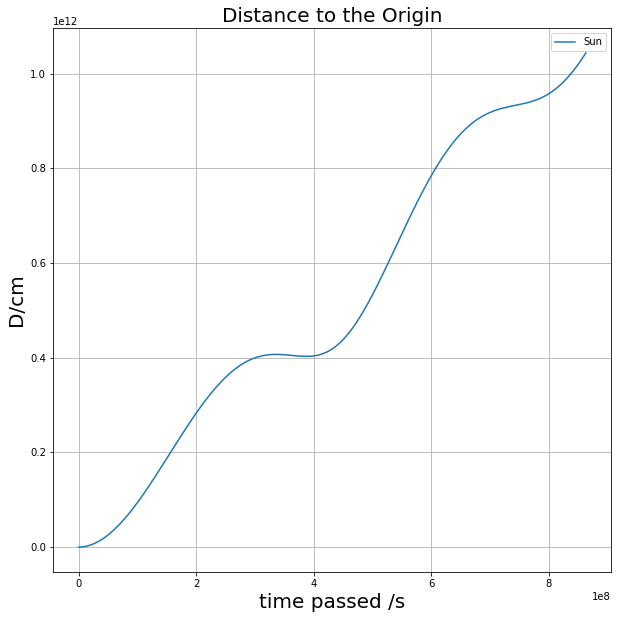

In [46]:
time = np.linspace(0, T-1, T) * t
radiuses = radii()
np.savetxt('radiuses.txt', radiuses)
plt.figure(figsize=(10,10))

names = np.array(['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'])

label_template = 'Object {i}'
for i in range(1):
    plt.plot(time, radiuses[i, :], label=names[i])
    
plt.title('Distance to the Origin', fontsize=20)
plt.xlabel('time passed /s', fontsize=20)
plt.ylabel('D/cm', fontsize=20)
plt.legend()
plt.grid()
plt.savefig('solarpathlinear.png')

In [ ]:
plt.figure()
plt.title('Distance to the Barycenter', fontsize=20)
plt.xlabel('what?')